In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all words
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Vocabulary and chars mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Hyperparameters
block_size = 4
embedding_size = 20
hidden_layer_size = 200
epochs = 100000
minibatch_size = 64
learning_rate = 0.1
lr_decay_factor = 10

In [5]:
# Create database
def create_db(words):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, y_train = create_db(words[:n1])
X_dev, y_dev = create_db(words[n1:n2])
X_test, y_test = create_db(words[n2:])

In [6]:
len(X_train), len(X_dev), len(X_test)

(182625, 22655, 22866)

In [7]:
# Initialize weights
g = torch.Generator().manual_seed(2147483647)
E = torch.randn((27, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_size), generator=g) * (5/3)/((block_size * embedding_size)**0.5)
#b1 = torch.randn(hidden_layer_size, generator=g) * 0.01
W2 = torch.randn((hidden_layer_size, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

bngain = torch.ones((1, hidden_layer_size))
bnbias = torch.zeros((1, hidden_layer_size))
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))

parameters = [E, W1, W2, b2, bngain, bnbias]

In [8]:
sum(p.nelement() for p in parameters)

22367

In [9]:
# Require grad
for p in parameters:
    p.requires_grad = True

Epoch: 0/100000: 3.2921
Epoch: 10000/100000: 2.1133
Epoch: 20000/100000: 2.3829
Epoch: 30000/100000: 2.1259
Epoch: 40000/100000: 1.9520
Epoch: 50000/100000: 2.0083
Epoch: 60000/100000: 2.1257
Epoch: 70000/100000: 1.8746
Epoch: 80000/100000: 1.9710
Epoch: 90000/100000: 2.1944


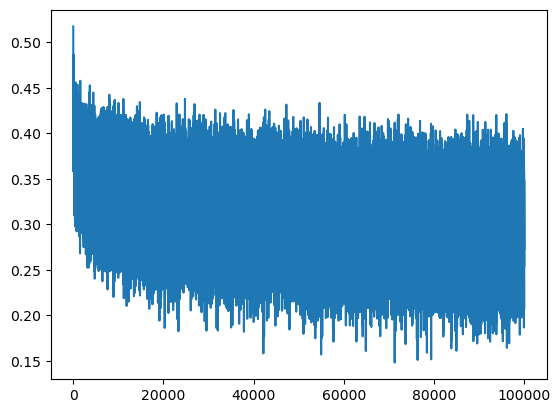

In [10]:
# Gradient descent
lossi = []
stepi = []
for i in range(epochs):
    # construct minibatch
    ix = torch.randint(0, X_train.shape[0], (minibatch_size,), generator=g)
    Xb, yb = X_train[ix], y_train[ix]

    # forward pass
    emb = E[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batchnorm
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        lr = learning_rate
        if i > int(0.9*epochs):
            lr /= lr_decay_factor
        p.data += -learning_rate * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    if i%10000 == 0:
        print(f'Epoch: {i}/{epochs}: {loss.item():.4f}')
plt.plot(stepi, lossi);

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_test)
    }[split]
    emb = E[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batchnorm
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

train 1.9658575057983398
dev 2.075390338897705
test 2.0687508583068848


In [15]:
# Sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = E[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

aces.
rokaan.
akringwan.
lex.
camariela.
ki.
gracerilee.
race.
donsa.
alahnie.
marki.
nora.
camra.
daionny.
aidan.
teshvy.
elia.
rexon.
codie.
mavika.
